# Introduction

This is the final project of Wicaksono Wijono and Minsu Yeom for the Machine Learning with Probabilistic Programming course.

## Motivation

We want to build a model of currency exchange rates for GBP, USD, and JPY. The observed exchange rates are GBPUSD, GBPJPY, USDJPY, and their reciprocals (we assume zero spread). Here, USDJPY = 100 means 1 USD buys us 100 JPY. 

Forecasting each exchange rate separately might imply arbitrage opportunities, inconsistent with the efficient market assumption. Suppose we forecast USDJPY = 100, JPYGBP = 0.01, and GBPUSD = 1.5. Then

$$\frac{USD}{JPY} \times \frac{JPY}{GBP} \times \frac{GBP}{USD} = 100 \times 0.01 \times 1.5 = 1.5$$

We can traverse the path $USD \to JPY \to GBP \to USD$ for 50% profit per cycle with no risk. Generally, arbitrage opportunities do not exist, so these forecasts are inconsistent with the real world.

To satisfy the no-arbitrage constraint, we can model individual currency values and assert the exchange rates are ratios of these hidden values. Even though $\frac{USD}{JPY}$ is written as a fraction, it is a single variable; the fraction is notational convenience. We want the fraction to be an actual ratio of two variables so the variables can "cancel out" and evaluate to 1 no matter the cycle.

We forecast the log of the exchange rates: $log(\frac{USD}{JPY}) = log(USD) - log(JPY)$. This has two major benefits. First, we can express observations as linear combinations of hidden variables. Second, we can explicitly model USD and JPY as geometric Brownian motion.

The second part has some subtleties. We cannot model $X = log(\frac{USD}{JPY})$ as Brownian motion $X_{t+1} - X_t \sim \mathcal N(0, \sigma^2)$ because that implies the exchange rate will keep going up. Recall that if $Y \sim \mathcal N(\mu, \sigma^2)$, then $\mathbb E[e^{Y}] = e^{\mu + \frac 12 \sigma^2} > 1$ when $\mu = 0$. If we model both $log(\frac{USD}{JPY})$ and $log(\frac{JPY}{USD})$ as Brownian motion with zero drift, then both exchange rates will go up over time, which is absurd.

However, allowing both $log(USD)$ and $log(JPY)$ go up in value over time is perfectly reasonable. For instance, if USD goes up slower than JPY, but both are going up, then the exchange rate USDJPY will go down. Therefore, allowing an individual currency to be geometric Brownian motion leads to a consistent model. Furthermore, we will be able to tell at a glance which currencies are strengthening or weakening by plotting the latent states over time.

## Data

We obtained 1-minute interval exchange data from __[Philippe Remy's Github](https://github.com/philipperemy/FX-1-Minute-Data)__ and worked on USD, GBP, and JPY exchange rates in May 2019. We took a small sample where the market is continuously open. Missing values are assumed to be missing because the exchange rate has not changed since the last measurement, so we impute with the last observed value.

# (Adaptive) Kalman Filter

For an excellent overview of the intuition please see __[Kalman Filter Demystified](https://arxiv.org/pdf/1811.11618.pdf)__. The model assumes the observed values y are linear combinations of latent variables x. Here, x is log currency while y is log exchange rate. We assume x is Brownian motion and the transition matrix is $I$ so we omit it.

$$x_{t+1} = x_{t} + u_{t+1}$$

$$y_{t+1} = B x_{t+1} + v_{t+1}$$

$$u \sim MVN(0, \Sigma_p)$$

$$v \sim MVN(0, \Sigma_m)$$

For this setup, the Kalman Filter is the optimal estimator. We will limit ourselves to the Gaussian assumption. For our model the equations become:

$$\begin{pmatrix} ln(GBP)_{t+1} \\ ln(JPY)_{t+1} \\ ln(USD)_{t+1} \end{pmatrix} = \begin{pmatrix} ln(GBP)_t \\ ln(JPY)_t \\ ln(USD)_t \end{pmatrix} + u_{t+1}$$

$$\begin{pmatrix} ln(\frac{GBP}{JPY})_{t+1} \\ ln(\frac{GBP}{USD})_{t+1} \\ ln(\frac{USD}{JPY})_{t+1} \end{pmatrix} = \begin{pmatrix} 1 & -1 & 0 \\ 1 & 0 & -1 \\ 0 & -1 & 1 \end{pmatrix} \begin{pmatrix} ln(GBP)_{t+1} \\ ln(JPY)_{t+1} \\ ln(USD)_{t+1} \end{pmatrix} + v_{t+1}$$

## What is a Filter?

The terms filter and smoother in the Kalman Filter literature have different meanings from their statistical counterparts. A filter only sees past and current data and does not know of the future, whereas a smoother only sees future and current data. As an oversimplification, if we use moving averages, then a sliding window from $t-2$ to $t$ is a filter, while a sliding window from $t$ to $t+2$ is a smoother. (In reality, this is not the case becasue a filter and smoother in KF are not convolutions!) In this illustration, the blue line is the observed values, while the red line is the filtered values.

<img src="gbpusd_example.jpeg" width = "500" />

## Continuous State Space Model

<img src="HMM.png" width = "500" />

__[<center>Image source</center>](http://www.davidsbatista.net/blog/2017/11/11/HHM_and_Naive_Bayes/)__

A Kalman Filter is the continuous analog of a Hidden Markov Model. The first equation governs the transition of the hidden states while the second equation governs the emissions. The Kalman Filter is commonly used for navigation systems, so think of the hidden state as your car's true position while the measurements are GPS readings. The continuity firmly asserts that a car cannot teleport.

However, the continuity makes the problem intractable. We can __[estimate latent states in HMM](http://pyro.ai/examples/hmm.html)__ by marginalizing out the finite number of states. When we have uncountably infinite number of possible hidden states, there is no way to marginalize them out. A Kalman Filter is much more difficult than an HMM.

## Connection to Normal-Normal Conjugacy

Consider a univariate random walk with increments $\mathcal N(0, \sigma^2_p)$ and our measurements $y$ have an error $\sim \mathcal N(0, \sigma^2_m)$. 

Then the Kalman Filter reduces to a Normal-Normal conjugacy relationship with unknown mean:

$$\mu_{t+1} = \frac{\frac{1}{Var(\mu_t) + \sigma^2_p} \mu_t + \frac{1}{\sigma^2_m} y}{\frac{1}{Var(\mu_t) + \sigma^2_p} + \frac{1}{\sigma^2_m}}$$       
$$Var(\mu_{t+1}) = \frac{1}{\frac{1}{Var(\mu_t) + \sigma^2_p} + \frac{1}{\sigma^2_m}}$$

The Kalman Filter is the optimal estimator because it gives us the posterior mode = mean = median. We cannot do any better.


## Parameter Estimation

In virtually all real-world cases, the variances are unknown hyperparameters. And like most machine learning algorithms, predictive performance depends on how the hyperparameters are tuned. In the univariate case, the only thing that matters is the ratio $\tau = \frac{\sigma^2_m}{\sigma^2_p}$ as n gets large. When $\tau$ is large, then our states don't move as much from $t$ to $t+1$ since we think our measurements are noisy. On the other hand, if $\tau$ is small then our states move very close to our observations since we believe the measurements are accurate. Here is a randomly generated random walk with a prior state of 0 and variance of 1 with different $\tau$:

<img src="tau_example.jpeg" width = "500" />

Likewise, for the multivariate case, the simplest model is to set $\Sigma_m = I_m$ and $\Sigma_p = \tau I_p, \tau \in \mathbb R^+$ and the problem reduces to estimating a single parameter. The next step up in complexity is to use the mean-field variational family: diagonal covariance matrices where we estimate each diagonal element separately.

However, a priori, this is too simple. We expect some currencies to be more stable than others, and exchange rates with the same underlying currency should be correlated with each other. In __[ADVI](https://arxiv.org/pdf/1603.00788.pdf)__, it is noted that financial assets have enough complexity that a full covariance matrix tends to perform much better than the mean-field variational family. Also, if our parameters of interest are the covariance matrices themselves, then mean-field should be avoided. Therefore, we want to estimate full-rank matrices.

## Adaptivity

Many financial time series exhibit volatility clustering, so models like GARCH are popular in finance. We want to capture this dynamic and let the covariance matrices vary over time. $\Sigma_p$ might increase because of changes in government policy. $\Sigma_m$ might increase in times of market uncertainty.

# Big Problem

We ended up not using Pyro because, as we found out, this problem is not suited for probabilistic programming (i.e. MCMC or VI). In __[Advances in Variational Inference](https://arxiv.org/pdf/1711.05597.pdf)__ it is noted that VI really struggles with time series, and it is still an open area of research. __[Sequential Monte Carlo](https://www.cs.ubc.ca/~arnaud/samsi/samsi_lec1.pdf)__ (particle filtering) is the state-of-the-art for MCMC on time series, but that is more concerned about estimating distributions of states at given time points. The __[Kalman Filter implementation in Pyro](http://docs.pyro.ai/en/stable/contrib.tracking.html#module-pyro.contrib.tracking.extended_kalman_filter)__ require us to supply one covariance, which we are trying to estimate.

Time series models are hard to fit because the likelihood cannot be factored nicely. The most relaxed assumption we can have is at least first-order Markov process. In our case, assuming $\theta$ is all the hyperparameters that are *not* time-varying, the likelihood is

$$ p(y_t, x_t |\theta ) = p(x_0)\ \prod_{t=1}^n p(y_t | x_t, \theta )\ p(x_t | x_{t-1}, \theta) $$

If we know $\theta$ then this is easy to compute. If we want to estimate $\theta$, we run into problems.

We cannot evaluate the gradient with respect to $\theta$ on the entire dataset. Or rather the computation is prohibitively expensive. When $\theta$ changes, so does our estimate of $x_t$ (i.e. $x_t$ is a function of $\theta$ annd $x_{i<t}$), so it is not clear how a change in $\theta$ might affect the likelihood. Automatic differentiation will have to go through the entire recursion for a single evaluation. Once we let $\theta$ be time-varying, then $\theta$ becomes a function of $x$ and $\theta_{i<t}$.

This is not readily obvious, but: **We cannot use standard inference algorithms!** Gradient-based VI methods don't work. HMC and NUTS need to evaluate gradients. We cannot use Gibbs because the posterior is not conditionally conjugate. And Metropolis-Hastings will have close to 0% acceptance probability for even slightly big covariance matrices. 

Another subtle implication of the problem formulation is that we cannot take first differences. One straightforward way to predict nonstationary time series is to predict the first differences $x_{t+1} - x_t$. However, here $x$ is unobserved for all values of t.

An EM approach is better-suited for this kind of problem, where we alternate between estimating $\theta$ while holding $X$ fixed and estimating $X$ while holding $\theta$ fixed. Therefore, we do EM the old-fashioned way.

We cannot use stochastic methods because the observations are not exchangeable, even assuming $\theta$ is fixed. The observations arrive one by one in a specific order. Ideally, we want to learn the $\theta$ in an online fashion, since this *is* a filtering problem.

Ideally, we want to provide a posterior distribution on $\theta$:

$$p(\theta | y) = \frac{\int_X p(y|x, \theta)\ p(x|\theta)\ p(\theta)\ dx}{\int_X \int_\Theta p(y|x, \theta)\ p(x|\theta)\ p(\theta)\ d\theta\ dx}$$

This looks downright impossible. We have to get creative.

## Possible Solutions

Funny story. I added this section after the development of the algorithm. I printed out a stack of papers on AKF and somehow it got lost in the folder until I saw them while shuffling through papers. So our proposed algorithm was developed without knowing what online EMAKF and VBAKF are. Of course I can't prove it, and it's up to you whether to believe it or not.

__[A New AKF](https://link.springer.com/article/10.1007/s00034-019-01053-w)__ provides a nice overview of the available approaches:

* SHAKF uses moments-matching but it might not even converge to the right $\Sigma$.
* __[IAKF](https://link.springer.com/content/pdf/10.1007/s001900050236.pdf)__ updates the covariances matrices using the residuals at each time step. However, the updates might yield $\Sigma$ that is not positive definite, and it requires many observations for it to provide a good estimate. 
* MMAKF averages several Kalman Filters with static covariances matrices, and the task is to update the model weights over time.
* __[EMAKF](https://www.researchgate.net/profile/Yulong_Huang3/publication/320026046_A_New_Adaptive_Extended_Kalman_Filter_for_Cooperative_Localization/links/5b5e6609a6fdccf0b2006714/A-New-Adaptive-Extended-Kalman-Filter-for-Cooperative-Localization.pdf)__ (online) does EM at every time step to update the $\Sigma$.
* VBAKF for the standard KF setup uses the normal and inverse Wishart distributions as the variational family for the conjugacy. Other distributions might be used for extended setups. See __[here](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8025799)__, __[here](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4796261)__, __[here](https://arxiv.org/pdf/1412.5307.pdf)__, and __[here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.431.6838&rep=rep1&type=pdf)__. The common approach is indeed to add a forgetting hyperparameter that needs to be tuned.

# Model Fitting

The pseudocode of the algorithm:

```python
initialize priors with kalman_smoother() on burn-in samples
counter = 1
do:
    iter = 0
    while psis_k < 0.7:
        iter = iter + 1
        forward_pass(data[counter:])
    kalman_smoother(data[counter:(counter + iter)])
    update hyperparameters
    counter = counter + iter
until went through all observations
```

Why does this algorithm make sense? Think of the maximum likelihood estimates from kalman_smoother() as our observation, and we get our posterior by taking the weighted average of our prior mean and MLE. We cannot use the $X$ generated by the prior $\Sigma$ because that's not our "observations"--that's what we *think* the observations should be based on our prior. To get the MLE, we need a smoother, but our goal is to build a filter.

The solution is to run a smoother on a small subset of the historical data and incorporate that into our prior. While the estimate should be better if we run the smoother on the entire historical dataset, the estimation will get slower and slower over time. It defeats the purpose of the Kalman Filter, in that we only need the last few observations and forget about all previous ones, i.e. online learning. If the $\Sigma$ are known, we only need to keep track of information from the two most recent time steps; any extra information adds nothing to our estimates.

Some might ask: why not update our priors at every time step? For n currencies, the number of hyperparameters we have to estimate is

$$\frac{n(n+1)}{2} + \frac{(_nC_2)(_nC_2+1)}{2}$$

We'd like a good handful of observations before we update this many parameters at once.

As for deciding *when* we should stop to update the model, PSIS is a good alarm. In sequential Monte Carlo filtering (particle filtering), we stop to resample when the distribution of likelihoods might have infinite variance. PSIS is designed to let us know when the likelihoods have infinite variance under the hyperparameters sampled from our prior.

To make the problem tractable, we use the inverse Wishart distribution, which is the distribution of covariance matrices characterized by the $\nu$ degrees of freedom parameter and the $S_{p \times p}$ scale parameter. Intuitively, $\nu$ is the number of observations we pad our prior with, and $S$ is $X^T X$ where $X$ is a $n \times p$ matrix where each row comes from a $MVN(0, \Sigma)$ distribution. The inverse Wishart has mode $\frac{S}{\nu}$ and mean $\frac{S}{\nu - p - 1}$. If this looks like the MLE vs unbiased estimator of variance, you're getting it. Thus, the update is

$$\nu_{t+1} = \nu_t + n$$

$$S_{t+1} = S_t + S_{obs}$$

Inverse Wishart is the worst way to parameterize a distribution of covariance matrices (compared to Cholesky or LKJ) but it is the most appropriate here for its conjugacy.

## Forward Pass

The forward pass estimates the latent variables by supplying a starting point, some observations, and the covariance matrices. We hold hyperparameters fixed and propagate through the system. The calculations are standard and can be found on Wikipedia. For our model assumptions:

$$P_{pred} = B P_{prior} B^T + \Sigma_p$$

$$e_t = y_t - B \hat x_{t-1}$$

$$W_t = B P_{pred} B^T + \Sigma_m$$

$$K_t = P_{pred} B^T W_t^{-1}$$

$$\hat x_t = \hat x_{t-1} + K_t e_t$$

$$P_{post} = (I - K_t B) P_{pred}$$

This looks daunting, but recall our univariate example. We are extending the updating equations to the multivariate normal case.

## Expectation Maximization

The typical inference algorithms (Rauch-Tung-Striebel and two-filter) provide the best estimates of all time points, including the initial state. The forward-backward algorithm is the continuous analog of the Viterbi algorithm for HMM. However, this will allow currencies to "teleport" from one minibatch to the next. Instead, we use EM to hold the initial state fixed. In the expectation step, we do a forward_pass() to estimate the latent states given the covariances. We implement this in the function kalman_smoother(), which is a misnomer but ok. In the maximization step, we do

$$\hat S_m = (Y-\hat Y)^T (Y-\hat Y)$$

$$\hat S_p = \sum_t (X_t - X_{t-1})^T (X_t - X_{t-1})$$

We iterate EM until convergence and update our inverse Wishart priors using the empirical scale matrices.


## Pareto-Smoothed-Importance-Sampling Leave-Future-Out CV (PSIS-LFO-CV)

__[PSIS](https://arxiv.org/pdf/1507.02646.pdf)__ is often used to __[approximate LOO-CV](https://arxiv.org/pdf/1507.04544.pdf)__ to assess model fit. __[PSIS-LFO-CV](https://arxiv.org/pdf/1902.06281.pdf)__ is a form of approximate LOO-CV for time series models, and the raw importance weights are proportional to

$$r_n^{(s)} \propto \prod_{i=1}^n p(y_{t+i}|\theta^{(s)})$$

Which is the likelihood of the observations given some sampled hyperparameters. In other words, we can sample some covariance matrices and hold them fixed, and given an initial state and some observations, we can go through the forward_pass() and evaluate the likelihood of the observations up to that time point. When the likelihoods start to have infinite variance, our model is becoming unstable because their predictions start to differ wildly, and we have to refit our model. 

This process is similar to the resampling step in Sequential Monte Carlo. When the likelihoods looks like they have infinite variance, the process is paused and the particles are sampled with probabilities proportional to their likelihood. In SMC, the resampling step might result in multiple copies of a single particle when the SMC is run long enough; in our case, we have the entire posterior distribution to sample from, so that should not happen.

Instead of refitting for the entire past, instead we use the conjugacy of the inverse Wishart to refit only using the data since the last time the model was refitted. This approach is partly motivated by our desire to fit this model to large datasets.

PSIS fits a generalized Pareto distribution to the right tail of the raw importance weights (the highest 20%) with some weakly regularizing prior (because otherwise fitting a GPD can be extremely hard). When the shape parameter $k$ goes above 0.5, the variance of the distribution is infinite. However, in the PSIS-LOO-CV paper, empirically the results are decent until $k > 0.7$, at which point we update our hyperparameters and start a new forward_pass().

## Code

### Data loading and preprocessing

In [1]:
import numpy as np
import pandas as pd
from Report_EM import forward_pass
%run Report_preprocessing.py
%run Report_EM.py

We took logs for each FX rate and multiply them by 100 to avoid numerical issues.

In [2]:
df.head()

,timestamp,gbpjpy,gbpusd,usdjpy,time_gap
0,2019-05-01 00:00:00,497.985989,26.565883,471.39349,1
1,2019-05-01 00:01:00,497.985989,26.565883,471.39349,1
2,2019-05-01 00:02:00,497.985989,26.565883,471.39349,1
3,2019-05-01 00:03:00,497.985989,26.565883,471.39349,1
4,2019-05-01 00:04:00,497.985989,26.565883,471.39349,1


### Running forward pass

In [3]:
training = df.loc[10000:11999, :]

forward_predictions, forward_states, \
    forward_post_covar, forward_innoation_covar = \
    forward_pass(data=training[:100],
                 initial_state=np.array([270, -220, 250]),
                 emit_mat=emit_mat,
                 meas_covar=1 *
                 np.identity(
                 nrow),
                 proc_covar=0.01 *
                 np.identity(
                 nrow),
                 post_covar=0.01*np.identity(nrow))
# Convert to pandas Data Frame
forward_predictions = pd.DataFrame(forward_predictions,
                                   columns=['timestamp'] +
                                   ccy_list + ['time_gap'])

In [4]:
%run Report_utils.py

In [5]:
gbpusd_dict = {'gbpusd(raw)': training.iloc[20:100, 1].shift(-1),
               'gbpusd(pred)': forward_predictions.iloc[20:100, 1].to_numpy()}

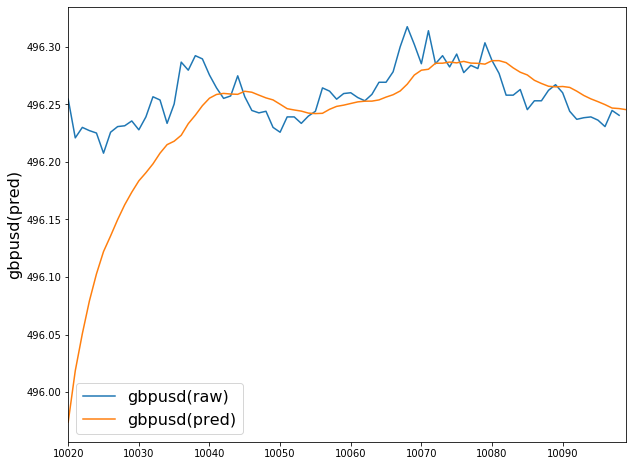

In [7]:
plot_multi(pd.DataFrame(gbpusd_dict), figsize=(10, 8))

With a forward pass, even with bad starting values the Filter will eventually figure out where to go as long as the prior is sufficiently weak.

### Running Kalman smoother

In [8]:
check_smoother = kalman_smoother(data=training[:1000],
                                 prior_state=np.array(
                                     [270, -220, 250], dtype=np.float64),
                                 emit_mat=emit_mat,
                                 prior_meas_df=100,
                                 prior_meas_scale=1**2 *
                                 np.identity(
                                     emit_mat.shape[1], dtype=np.float64),
                                 prior_proc_df=100,
                                 prior_proc_scale=0.1**2 *
                                 np.identity(
                                     emit_mat.shape[0], dtype=np.float64),
                                 post_covar=forward_post_covar
                                 )

In [9]:
gbpusd_dict = {'gbpusd(raw)':
               check_smoother['input_data'][0:100].loc[:, 'gbpusd'].shift(-1),
               'gbpusd(pred)':
               check_smoother['predicted_measurements'][0:100][:, -3]}

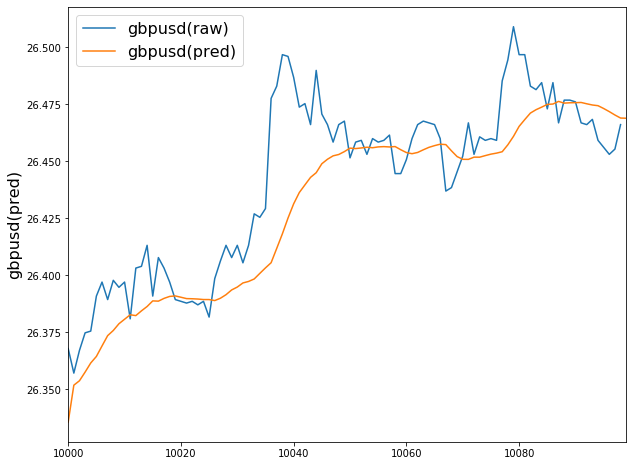

In [10]:
plot_multi(pd.DataFrame(gbpusd_dict), figsize=(10,8))

With a smoother, the initial value matters a lot. Had we picked better initial values, the smoother would likely do much better early in the time series. In our experience, a bad starting value causes the EM to never converge, so we supply initial values using a forward pass with a weak prior.

### Adaptive Kalman Filter

In [11]:
%run Report_adaptive_kf.py

In [12]:
check_smoother_init = kalman_smoother(
    data=df.loc[19499:19998, :],
    emit_mat=emit_mat,
    prior_state=np.array([0, 0, 0], dtype=np.float64),
    post_covar=10*np.identity(emit_mat.shape[0], dtype=np.float64),
    prior_proc_df=10,
    prior_proc_scale=10*0.1*np.identity(emit_mat.shape[0], dtype=np.float64),
    prior_meas_df=10,
    prior_meas_scale=10*0.1*np.identity(emit_mat.shape[0], dtype=np.float64)
)

In [13]:
check_akf = adaptive_kalman_filter(
    data=df.loc[19999:20498, :],
    emit_mat=emit_mat,
    burn_in=0,
    prior_state=check_smoother_init['states'][-1, 1:-1].astype(np.float64),
    prior_covar=check_smoother_init['post_covar'],
    innovation_covar=check_smoother_init['innovation_covar'],
    prior_proc_df=check_smoother_init['post_proc_df'],
    prior_proc_scale=check_smoother_init['post_proc_scale'],
    prior_meas_df=check_smoother_init['post_meas_df'],
    prior_meas_scale=check_smoother_init['post_meas_scale']
)

In [14]:
input_data = check_akf['input_data'].iloc[:, :-1]
input_data.iloc[:, 1:] = input_data.iloc[:, 1:] / 100
predictions = pd.DataFrame(check_akf['predicted_meas'],
                           columns=['timestamp'] + ccy_list + ['timegap'])
predictions.iloc[:, 1:-1] = predictions.iloc[:, 1:-1] / 100
plot_df = pd.merge(how='inner', left=input_data, right=predictions,
                   on='timestamp', suffixes=('_raw', '_pred'))
gbpjpy_dict = {'gbpjpy(raw)':plot_df.loc[:, 'gbpjpy_raw'].shift(-1),
               'gbpjpy(pred)':plot_df.loc[:, 'gbpjpy_pred']}

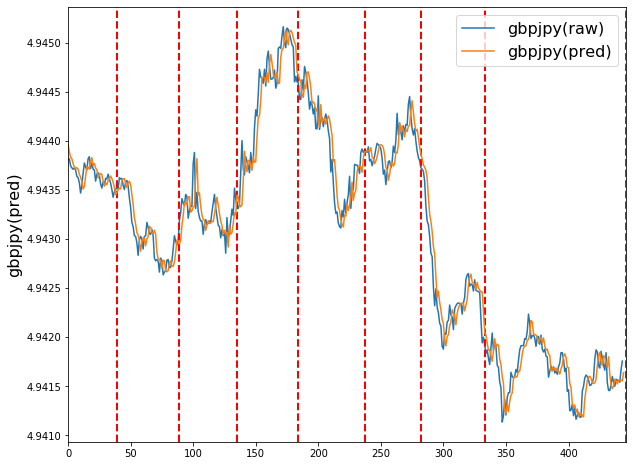

In [16]:
plot_multi(pd.DataFrame(gbpjpy_dict), figsize=(10, 8), vline=check_akf['breakpoints'])

We did the burn-in manually using the forward_pass() and kalman_smoother() earlier to supply good starting values. The vertical dashed lines show the time points where the hyperparameters were updated. 

Obviously the model is really bad. One audience member kindly pointed out that the model might've overfit to the training data. That is not the case! Because this is a filter, at each point it predicts $t+1$, it has only seen data up to point $t$.

The model has learned that $\Sigma_p$ is much larger in magnitude than $\Sigma_m$. In hindsight, this should've been obvious. If the market is perfectly efficient, then $\Sigma_m$ would be the 0 matrix. Since we think the market is pretty efficient, $\Sigma_m$ should be small. This implies that our forecast for $t+1$ should be extremely close to the value at time $t$. Think of it as, if we think a process is a random walk, then our best forecast is the value at the current state.

#### Latent states

In [17]:
gbp_lat_states = check_akf['states'][:,1]/100
jpy_lat_states = check_akf['states'][:,2]/100
states_dict = {'GBP_states':gbp_lat_states, 'JPY_states':jpy_lat_states}

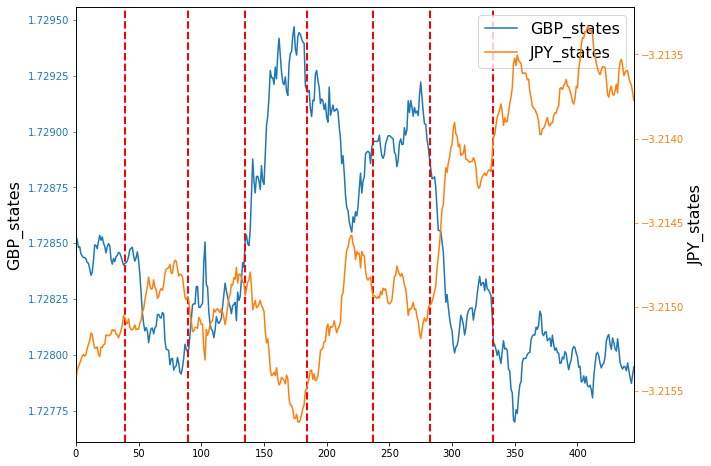

In [18]:
plot_multi_axes(pd.DataFrame(states_dict), figsize=(10, 8), vline=check_akf['breakpoints'])

As previously mentioned, one major strength of the model is that we can tell at a glance which currency is weakening or strengthening. The information from USD is not shown, but it influences how these states are estimated.

# Criticism

We started with strong theory and set out to build a model consistent with the theory. Like with many research problems, we didn't know at the start whether or not we'd get a satisfying conclusion. In our case, we are left unsatisfied.

The resulting model updates the covariance matrices over time, but the model implicitly assumes time-invariant covariance matrices. As more data is collected, $\nu$ becomes so big that the prior overwhelms any new data. __[Some papers](https://arxiv.org/ftp/arxiv/papers/1702/1702.00884.pdf)__ have suggested a "forgetting factor" $\alpha$ which shrinks the prior as time goes on. I personally like __[this formulation](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.431.6838&rep=rep1&type=pdf)__ :

$$\nu_{t+1} = \alpha (\nu_t - p - 1) + p + 1 + n$$
$$S_{t+1} = \alpha S_t + S_{obs}$$

The forgetting factor can be set perhaps by grid search. $\alpha = 1$ implies a static covariance matrix, while $\alpha = 0$ means we use the MLE from the latest minibatch every time we refit the model.

We suspect the resulting covariance estimates will be biased in favor of large $\Sigma_p$ and small $\Sigma_p$ because of the stopping times. The likelihoods will have high variance when the predicted states differ wildly. When the time series looks flat, then the predicted states should all be similar, and the stopping time will be longer; but when there is a downwards or upwards trend, then it is much easier to hit $k > 0.7$. This hunch is supported by the graph. Therefore, our MLE from EM will favor high process covariance.

In addition, the resulting predictions follow the observations anyway because the exchange rates are too volatile. No skirting around it: the predictions are terrible. It is clear from visual inspection. We think the main reason the model breaks down is because the intrinsic values do not follow a random walk, and perhaps an auto-regressive process is a better assumption. While we can __[adaptively estimate covariances in a stationary process](https://www.jstor.org/stable/pdf/2346910.pdf)__ it is not clear how to do so for a non-stationary process.

When we tried 5 currencies, the model breaks down. The number of parameters we have to estimate explodes very rapidly as the number of currencies goes up, and the forward_pass() stops earlier so we have even fewer observations to run through the EM. The latter is a known problem in particle filtering, which is why it doesn't work well in high dimensions.

In short, we tackled a problem that is beyond our skill level, and we did our best in cobbling together a new algorithm that partially achieves our objectives. 

Despite all this, being able to infer which currencies weaken or strengthen relative to other currencies and tying everything together into a no-arbitrage framework is pretty cool.

# References

__[Kalman Filter Demystified](https://arxiv.org/pdf/1811.11618.pdf)__ Benhamou (2018). Kalman filter demystified: from intuition to probabilistic graphical model to real case infinancial markets

__[Advances in Variational Inference](https://arxiv.org/pdf/1711.05597.pdf)__ Zhang et al. (2018). Advances in Variational Inference

__[Sequential Monte Carlo](https://www.cs.ubc.ca/~arnaud/samsi/samsi_lec1.pdf)__ Doucet. Sequential Monte Carlo: An Introduction

__[Adaptive Estimation](https://link.springer.com/content/pdf/10.1007/s001900050236.pdf)__ Mohamed and Schwarz (1998). Adaptive Kalman Filtering for INS/GPS

__[ADVI](https://arxiv.org/pdf/1603.00788.pdf)__ Kucukelbir et al. (2016). Automatic Differentiation Variational Inference

__[A New AKF](https://link.springer.com/article/10.1007/s00034-019-01053-w)__ Xu et al. (2018). A New Adaptive Kalman Filter with Inaccurate Noise Statistics

__[IAKF](https://link.springer.com/content/pdf/10.1007/s001900050236.pdf)__ Mohamed and Schwarz (1999). Adaptive Kalman Filtering for INS/GPS

__[EMAKF](https://www.researchgate.net/profile/Yulong_Huang3/publication/320026046_A_New_Adaptive_Extended_Kalman_Filter_for_Cooperative_Localization/links/5b5e6609a6fdccf0b2006714/A-New-Adaptive-Extended-Kalman-Filter-for-Cooperative-Localization.pdf)__ Huang et el. (2017). A New Adaptive Extended Kalman Filter for Cooperative Localization

__[VBAKF1](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8025799)__ Huang et al. (2017). A Novel Adaptive Kalman Filter With Inaccurate Process and Measurement Noise Covariance Matrices

__[VBAKF2](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4796261)__ Särkkä and Nummenmaa (2007). Recursive Noise Adaptive Kalman Filtering by Variational Bayesian Approximations

__[VBAKF3](https://arxiv.org/pdf/1412.5307.pdf)__ Ardeshiri et al. (2015). Approximate Bayesian Smoothing with Unknown Process and Measurement Noise Covariances

__[VBAKF4](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.431.6838&rep=rep1&type=pdf)__ Särkkä and Hartikainen (2013). Non-linear Noise Adaptive Kalman Filtering view Variational Bayes

__[PSIS](https://arxiv.org/pdf/1507.02646.pdf)__ Vehtari et al. (2019). Pareto Smoothed Importance Sampling

__[PSIS-LOO-CV](https://arxiv.org/pdf/1507.04544.pdf)__ Vehtari et al. (2016) Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC

__[PSIS-LFO-CV](https://arxiv.org/pdf/1902.06281.pdf)__ Bürkner et al. (2019). Approximate leave-future-out cross-validation for Bayesian time series models

__[Forgetting Factor](https://arxiv.org/ftp/arxiv/papers/1702/1702.00884.pdf)__ Akhlaghi et al. (2017) Adaptive Adjustment of Noise Covariance in Kalman Filter for Dynamic State Estimation